In [1]:
# load autoreload extension
%load_ext autoreload
%autoreload 2
%cd '/lhome/ific/a/aamerio/github/diffusion'
%pwd

/lhome/ific/a/aamerio/github/diffusion


'/lhome/ific/a/aamerio/github/diffusion'

In [2]:
import os
os.environ['JAX_PLATFORMS']="cpu"
# os.environ['JAX_PLATFORMS']="cuda"

In [3]:
import sys
# sys.path.append('/lhome/ific/a/aamerio/github/diffusion/src')
# sys.path.append('/home/zaldivar/Documents/Aurelio/Github/diffusion/src')
sys.path.append('./src')
sys.path.append('./reference/simformer-main/src/probjax')
sys.path.append('./reference/simformer-main/src/scoresbibm')

sys.path.append('../src')
sys.path.append('../reference/simformer-main/src/probjax')
sys.path.append('../reference/simformer-main/src/scoresbibm')

import os
# os.environ['JAX_PLATFORMS']="cpu"

In [4]:
import diffusion
from diffusion.sbi.transformer import Transformer
from diffusion.embedding import GaussianFourierEmbedding, SinusoidalEmbedding
from diffusion import sde as sde_ours

from scoresbibm.methods.sde import init_sde_related

In [5]:
import jax 
import jax.numpy as jnp
import numpy as np
from flax import nnx
from functools import partial

import matplotlib.pyplot as plt


from tqdm.auto import tqdm

In [6]:
print(jax.default_backend())
print(jax.devices())

cpu
[CpuDevice(id=0)]


# generate dataset

In [7]:
# we have two parameters, theta1 and theta2
# we have two outputs, y1 and y2, corresponding to the measurement with two different detectors

npoints = 2**10 #1024

nobs = 128_000
wavefun = lambda theta1, theta2, x: jnp.sin(theta1*x)*jnp.cos(theta2*x)


rng = jax.random.PRNGKey(42)
rng, key = jax.random.split(rng)
x1 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
x2 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
keys = jax.random.split(key, 3)
thetas = jax.random.normal(keys[0], (nobs,2))+0.5
noise1 = jax.random.normal(keys[1], (nobs,npoints))*0.3
noise2 = jax.random.normal(keys[2], (nobs,npoints))*0.3

xs1 = wavefun(thetas[:,0:1], thetas[:,1:2],x1) + noise1
xs2 = wavefun(thetas[:,0:1], thetas[:,1:2],x2) + noise2

xs1 = xs1.reshape(nobs,1,npoints)
xs2 = xs2.reshape(nobs,1,npoints)

xs = jnp.concatenate([xs1,xs2],axis=1)


In [8]:
xs.shape, thetas.shape

((128000, 2, 1024), (128000, 2))

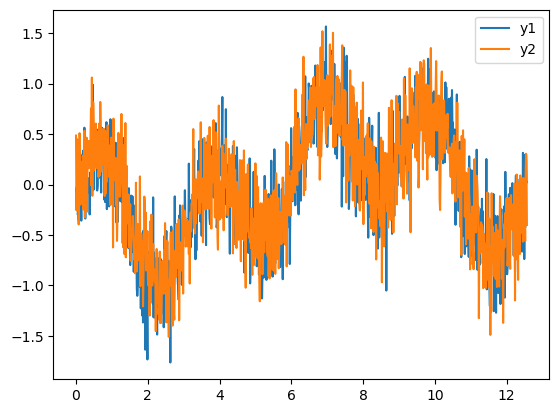

In [9]:
i=5
plt.plot(x1[0,:], xs1[i,0,:], label='y1')
plt.plot(x2[0,:], xs2[i,0,:], label='y2')
plt.legend()
plt.show()

# data preprocessing

In [10]:
thetas_mean = jnp.mean(thetas, axis=0, keepdims=True)
thetas_std = jnp.std(thetas, axis=0, keepdims=True)

thetas = (thetas - thetas_mean) / thetas_std

In [11]:
def z_score_thetas(thetas):
    thetas = (thetas - thetas_mean) / thetas_std
    return thetas

def un_z_score_thetas(thetas):
    thetas = thetas * thetas_std + thetas_mean
    return thetas

In [12]:
xs_mean = jnp.mean(xs, axis=0, keepdims=True)
xs_mean = jnp.mean(xs_mean, axis=-1, keepdims=True)
xs_std = jnp.std(xs, axis=0, keepdims=True)
xs_std = jnp.std(xs_std, axis=-1, keepdims=True)

xs = (xs - xs_mean) / xs_std

In [13]:
def z_score_xs(xs):
    xs = (xs - xs_mean) / xs_std
    return xs

def un_z_score_xs(xs):
    xs = xs * xs_std + xs_mean
    return xs

In [14]:
def ravel(data, axis=-1):
    flat_data, tree = jax.tree_util.tree_flatten(data)
    split_dims = np.cumsum(np.array([flat.shape[axis] for flat in flat_data]))[:-1]
    flat_data = jnp.concatenate(flat_data, axis=axis)
    def unravel(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        flat_data = jax.tree_util.tree_unflatten(tree, flat_data)
        return flat_data
    def unflatten(flat_data):
        flat_data = jnp.split(flat_data, split_dims, axis=axis)
        return flat_data 
    return flat_data, unravel, unflatten

In [15]:
data = {"theta0": thetas[:, 0][:, None], "theta1": thetas[:, 1][:, None], "x0": xs[:, 0], "x1": xs[:, 1]}
data_flat, unravel, unflatten = ravel(data)
theta_dim = 2
x_dim = data_flat.shape[-1] - theta_dim
node_id = jnp.arange(0, 4)
condition_mask = jnp.array([False]*theta_dim + [True]*x_dim)

In [19]:
# ve = sde.VESDE(2, sigma_min=1e-5, sigma_max=15.)
sde, T_min, T_max, weight_fn, output_scale_fn =  init_sde_related(data_flat, "vesde", sigma_min=1e-5, sigma_max=15.)

In [20]:
# we define a CNN to embed the data
class ConvEmbed(nnx.Module):
    def __init__(self, din, dout, *, rngs):
        features = 16
        padding = "SAME"
        self.activation = jax.nn.gelu
        dlin = din
        conv1 = nnx.Conv(1, features, kernel_size=(9,), strides=2, padding=padding, rngs=rngs) # 512
        dlin/=2
        bn1 = nnx.BatchNorm(features, rngs=rngs)
        conv2 = nnx.Conv(features, features*2, kernel_size=(6,), strides=2, padding=padding, rngs=rngs) # 256
        dlin/=2
        features *= 2
        bn2 = nnx.BatchNorm(features, rngs=rngs)
        conv3 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 128
        dlin/=2
        features *= 2
        bn3 = nnx.BatchNorm(features, rngs=rngs)
        conv4 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 64
        dlin/=2
        features *= 2
        bn4 = nnx.BatchNorm(features, rngs=rngs)
        conv5 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 32
        dlin/=2
        features *= 2
        bn5 = nnx.BatchNorm(features, rngs=rngs)
        conv6 = nnx.Conv(features, features, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 16
        dlin/=2
        bn6 = nnx.BatchNorm(features, rngs=rngs)
        conv7 = nnx.Conv(features, features*2, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 8
        dlin/=2
        features*=2
        bn7 = nnx.BatchNorm(features, rngs=rngs)
        conv8 = nnx.Conv(features, features, kernel_size=(3,), strides=2, padding=padding, rngs=rngs) # 4
        dlin/=2
        bn8 = nnx.BatchNorm(features, rngs=rngs)
        dlin*=features

        self.conv_layers = [conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8]
        self.bn_layers = [bn1, bn2, bn3, bn4, bn5, bn6, bn7, bn8]

        self.linear = nnx.Linear(int(dlin), dout, rngs=rngs)
    
    def __call__(self, x):
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            x = self.activation(x)
            x = self.bn_layers[i](x)
        
        #flatten x
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        
        return x[..., None,:]



In [21]:
x_dim

2048

In [22]:
token_dim = 100
id_dim = 40
cond_dim = 10
rngs = nnx.Rngs(42)


class Simformer(nnx.Module):
    def __init__(self, din, *, rngs):
        fourier_features = 128
        self.unflatten = unflatten
        embedding_net1 = lambda x: jnp.repeat(x, token_dim, axis=-1)
        embedding_net2 = ConvEmbed(din, token_dim, rngs=rngs)
        self.embedding_nets = [
            embedding_net1,
            embedding_net1,
            embedding_net2,
            embedding_net2,
        ]
        self.time_embedder = GaussianFourierEmbedding(fourier_features, rngs=rngs)
        # self.time_embedder = SinusoidalEmbedding(fourier_features)
        self.id_embedder = nnx.Embed(
            num_embeddings=4, features=id_dim, rngs=rngs
        )  # hk.Embed(4, id_dim)
        self.condition_token = nnx.Param(0.01*jnp.ones((1, 1, cond_dim)))
        self.output_scale_fn = output_scale_fn

        self.total_tokens = token_dim + id_dim + cond_dim

        self.transformer = Transformer(
            din=self.total_tokens,
            dcontext=fourier_features,
            num_heads=4,
            num_layers=8,
            features=20,
            widening_factor=3,
            dropout_rate=0,
            num_hidden_layers=1,
            act=jax.nn.gelu,
            skip_connection_attn=True,
            skip_connection_mlp=True,
            rngs=rngs,
        )

        self.output_fn = [nnx.Linear(self.total_tokens,1,rngs=rngs), nnx.Linear(self.total_tokens,1,rngs=rngs), nnx.Linear(self.total_tokens,npoints,rngs=rngs), nnx.Linear(self.total_tokens,npoints,rngs=rngs)]


    def __call__(self, data, t, data_id, condition_mask, edge_mask=None):
        data = self.unflatten(data)
        
        data_embedded = jax.tree.map(lambda x, net: net(x[..., :,None]), data, self.embedding_nets)

        data_embedded = jnp.concatenate(data_embedded, axis=-2)
        
        _, current_nodes, _ = data_embedded.shape
        
        
        id_embedding = self.id_embedder(data_id)
        id_embedding = jnp.broadcast_to(
            id_embedding, data_embedded.shape[:-1] + (id_dim,)
        )
        tokens = jnp.concatenate([data_embedded, id_embedding], axis=-1)
        # time = self.time_embedder(t[..., None])
        time = self.time_embedder(t)
        
        condition_mask = self.unflatten(condition_mask)
        condition_mask = jax.tree.map(lambda x: jnp.any(x, axis=-1, keepdims=True), condition_mask)
        condition_mask = jnp.concatenate(condition_mask, axis=-1)
        condition_mask = condition_mask.reshape(-1, current_nodes, 1)
        condition_token = condition_mask * self.condition_token
    
        condition_token = jnp.broadcast_to(
            condition_token, tokens.shape[:-1] + (cond_dim,)
        )

        tokens = jnp.concatenate([tokens, condition_token], -1)

        h = self.transformer(tokens, context=time, mask=edge_mask)
        out = jnp.split(h, current_nodes, axis=-2)
        out = jax.tree.map(lambda x, fn: fn(x), out, self.output_fn)
        out = jnp.concatenate(out, axis=-1)
        out = jnp.squeeze(out, axis=-2)
        out = self.output_scale_fn(t, out)

        return out

In [24]:
score_model = Simformer(x_dim//2, rngs=nnx.Rngs(42))

In [25]:
res=score_model( data_flat[:10], jnp.ones((1,)), node_id, condition_mask)

In [26]:
res[0][0].item()

-0.0017918747616931796

In [25]:
import optax
optimizer = nnx.Optimizer(score_model, optax.adam(1e-4))  

In [26]:

def denoising_score_matching_loss(
    # params: PyTree,
    # key: PRNGKey,
    # times: Array,
    # xs_target: Array,
    # loss_mask: Optional[Array],
    # *args,
    # model_fn: Callable,
    # mean_fn: Callable,
    # std_fn: Callable,
    # weight_fn: Callable,
    # axis: int = -2,
    # rebalance_loss: bool = False,
    score_model,
    key,
    times,
    xs_target,
    loss_mask,
    *args,
    mean_fn,
    std_fn,
    weight_fn,
    axis: int = -2,
    rebalance_loss: bool = False,
    **kwargs): 
    """This function computes the denoising score matching loss. Which can be used to train diffusion models.

    Args:
        params (PyTree): Parameters of the model_fn given as a PyTree.
        key (PRNGKey): Random generator key.
        times (Array): Time points, should be broadcastable to shape (batch_size, 1).
        xs_target (Array): Target distribution.
        loss_mask (Optional[Array]): Mask for the target distribution. If None, no mask is applied, should be broadcastable to shape (batch_size, 1).
        model_fn (Callable): Score model that takes parameters, times, and samples as input and returns the score. Should be a function of the form model_fn(params, times, xs_t, *args) -> s_t.
        mean_fn (Callable): Mean function of the SDE.
        std_fn (Callable): Std function of the SDE.
        weight_fn (Callable): Weight function for the loss.
        axis (int, optional): Axis to sum over. Defaults to -2.
        

    Returns:
        Array: Loss
    """
    eps = jax.random.normal(key, shape=xs_target.shape)
    mean_t = mean_fn(times, xs_target)
    std_t = std_fn(times, xs_target)
    xs_t = mean_t + std_t * eps
    
    if loss_mask is not None:
        loss_mask = loss_mask.reshape(xs_target.shape)
        xs_t = jnp.where(loss_mask, xs_target, xs_t)
    
    score_pred = score_model(xs_t, times , *args, **kwargs)
    score_target = -eps / std_t

    loss = (score_pred - score_target) ** 2
    if loss_mask is not None:
        loss = jnp.where(loss_mask, 0.0,loss)
    loss = weight_fn(times) * jnp.sum(loss, axis=axis, keepdims=True)
    if rebalance_loss:
        num_elements = jnp.sum(~loss_mask, axis=axis, keepdims=True)
        loss = jnp.where(num_elements > 0, loss / num_elements, 0.0)
    loss = jnp.mean(loss)

    return loss

In [27]:
def loss_fn_(score_model, key, data, node_id):
    key_times, key_loss, key_condition = jax.random.split(key,3)
    times = jax.random.uniform(key_times, (data.shape[0],), minval=T_min, maxval =T_max)
    condition_mask1 = jnp.array([False]*theta_dim + [True]*x_dim)
    condition_mask2 = jnp.array([False]*theta_dim + [True]*(x_dim//2) + [False]*(x_dim//2))
    condition_mask3 = jnp.array([False]*theta_dim + [False]*(x_dim//2) + [True]*(x_dim//2))

    edge_mask1 = jnp.ones((4,4), dtype=bool)
    # Partial posterior
    edge_mask2 = edge_mask1.at[:, 2].set(False)
    edge_mask2 = edge_mask2.at[2, :].set(False)
    # Partial posterior 2
    edge_mask3 = edge_mask1.at[:, 3].set(False)
    edge_mask3 = edge_mask3.at[3, :].set(False)
    
    edge_masks = jax.random.choice(key_condition, jnp.stack([edge_mask1, edge_mask2, edge_mask3]), (data.shape[0],))
    condition_mask = jax.random.choice(key_condition, jnp.stack([condition_mask1, condition_mask2, condition_mask3]), (data.shape[0],))
    l_mask = jnp.broadcast_to(condition_mask1, (data.shape[0],) + condition_mask1.shape)
    
    loss = denoising_score_matching_loss(score_model, key_loss, times, data, l_mask, node_id,  mean_fn = sde.marginal_mean, std_fn=sde.marginal_stddev, weight_fn=weight_fn, edge_mask=edge_masks, condition_mask=condition_mask, axis=-1)
    return loss

@nnx.jit
def train_step(score_model, optimizer, data, node_id, rngs):
    loss_fn = lambda score_model: loss_fn_(score_model, rngs.dist(), data, node_id)
    loss, grads = nnx.value_and_grad(loss_fn)(score_model)
    optimizer.update(grads)  # In place updates.
    return loss

In [28]:
nepochs = 5
batch_size = 128
batch_steps = nobs // batch_size 
subkey = rngs.batch()
data_batches = jax.random.choice(subkey, data_flat, (batch_steps, batch_size), replace=False)

train_step(score_model, optimizer, data_batches[0], node_id, rngs)

Array(56.397, dtype=float32)

In [30]:
nepochs = 10
batch_size = 128
batch_steps = nobs // batch_size 

score_model.train()

for _ in range(nepochs):
    pbar = tqdm(range(batch_steps))
    subkey = rngs.batch()
    data_batches = jax.random.choice(subkey, data_flat, (batch_steps, batch_size), replace=False)
    l = 0
    for j in pbar:
        loss = train_step(score_model, optimizer, data_batches[j], node_id, rngs)
        l += loss.item()
        if j % 10 == 0:
            pbar.set_postfix(loss=l/10)
            l = 0
    # print(l)

score_model.eval()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# save and restore model
see https://colab.research.google.com/drive/1ozln9ejG7eRtxvbkqHYU3K6OyPvveH9w?usp=sharing#scrollTo=HleXYZe3Fn38

In [ ]:
# we save the model using orbax
from orbax import checkpoint as ocp
ckpt_dir = "/lhome/ific/a/aamerio/data/diffusion/checkpoints/state_score_model"
ckpt_dir = str(ocp.test_utils.erase_and_create_empty(ckpt_dir))


graphdef, state = nnx.split(score_model)

# Flatten the model state
model_state = state.flat_state()

# Generating a 'true' model state for later comparison to restored state
model_state_true = state.flat_state()

# checkpointer = ocp.StandardCheckpointer()

# checkpointer.save(ckpt_dir + "/state_score_model", state)
def prepare_state_for_saving(model_state):
    """
    Converts RNG keys in the model state to arrays of uint32 numbers for saving.

    Args:
        model_state (Dict): The flattened model state.

    Returns:
        Dict: The updated model state with RNG keys converted.
    """
    new_model_state = model_state.copy()
    for key_path, var_state in new_model_state.items():
        if var_state.type == nnx.RngKey:
            # Convert the RNG key into an array of uint32 numbers
            uint32_array = jax.random.key_data(var_state.value)
            # Replace the RNG key in the model state with the array
            new_model_state[key_path] = nnx.VariableState(
                type=nnx.Param,
                value=uint32_array
            )
    return new_model_state
model_state_to_save = prepare_state_for_saving(model_state)
# Define CheckpointManagerOptions
options = ocp.CheckpointManagerOptions(
    max_to_keep=2,
    keep_checkpoints_without_metrics=False,
    create=True,
)

# Initialize the CheckpointManager
checkpoint_manager = ocp.CheckpointManager(
    directory=ckpt_dir,
    options=options,
)
# Save the checkpoint using StandardSave
checkpoint_manager.save(
    step=0,
    args=ocp.args.StandardSave(nnx.State.from_flat_path(model_state_to_save)),
    force=True,
)

# Ensure checkpointing is finished
checkpoint_manager.wait_until_finished()


## restore model

In [ ]:

ckpt_dir = "/lhome/ific/a/aamerio/data/diffusion/checkpoints/state_score_model"

# Define CheckpointManagerOptions
options = ocp.CheckpointManagerOptions(
    max_to_keep=2,
    keep_checkpoints_without_metrics=False,
    create=True,
)

# Initialize the CheckpointManager
checkpoint_manager = ocp.CheckpointManager(
    directory=ckpt_dir,
    options=options,
)
# New model, with same structure
new_model = Simformer(x_dim//2, rngs=nnx.Rngs(42))
# Create a placeholder for the model state shape
model_shape = nnx.eval_shape(lambda: nnx.State.from_flat_path(model_state_to_save))

# Restore the model state from the checkpoint
restored_model_state = checkpoint_manager.restore(
    0,
    args=ocp.args.StandardRestore(model_shape),
)
def restore_rng_keys(model_state):
    """
    Converts arrays of uint32 numbers back to RNG keys in the model state.

    Args:
        model_state (Dict): The flattened model state.

    Returns:
        Dict: The updated model state with RNG keys restored.
    """
    new_model_state = model_state.copy()
    for key_path, var_state in new_model_state.items():
        if var_state.type == nnx.Param and ('rngs' in key_path) and (key_path[-1] == 'key'):
            # Convert the array back to an RNG key
            rng_key = jax.random.wrap_key_data(var_state.value)
            # Replace the array with the RNG key
            new_model_state[key_path] = nnx.VariableState(
                type=nnx.RngKey,
                value=jax.random.wrap_key_data(var_state.value),
                get_value_hooks=(),
                set_value_hooks=(),
                create_value_hooks=(),
                add_axis_hooks=(),
                remove_axis_hooks=(),
                tag='default',
            )
    return new_model_state
# Flatten the restored model state
restored_state_flat = restored_model_state.flat_state()

# Convert arrays back to RNG keys
restored_state_flat = restore_rng_keys(restored_state_flat)
# update the model with a checkpoint
# Create nnx.State from the restored flat state
restored_state = nnx.State.from_flat_path(restored_state_flat)

# Update the model with the restored state
nnx.update(new_model, restored_state)

# now we do the backward diffusion to get the posterior

In [31]:
ve = sde_ours.VESDE(2050, sigma_min=1e-5, sigma_max=15.)

In [32]:
nobs = 100

rng = jax.random.PRNGKey(420)
rng, key = jax.random.split(rng)
x1 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
x2 = np.linspace(0, 4*np.pi, npoints).reshape(1,-1)
thetas_test = jax.random.normal(key, (nobs,2))+0.2
noise1 = jax.random.normal(key, (nobs,npoints))*0.3
noise2 = jax.random.normal(key, (nobs,npoints))*0.3

xs1 = wavefun(thetas_test[:,0:1], thetas_test[:,1:2],x1) + noise1
xs2 = wavefun(thetas_test[:,0:1], thetas_test[:,1:2],x2) + noise2

xs1 = xs1.reshape(nobs,1,npoints)
xs2 = xs2.reshape(nobs,1,npoints)

xs_test = jnp.concatenate([xs1,xs2],axis=1)

In [33]:
thetas_test = (thetas_test - thetas_mean) / thetas_std
xs_test = (xs_test - xs_mean) / xs_std

In [34]:
data_test = {"theta0": thetas_test[:, 0][:, None], "theta1": thetas_test[:, 1][:, None], "x0": xs_test[:, 0], "x1": xs_test[:, 1]}
data_test_flat, _, _ = ravel(data_test)

In [35]:
edge_mask = jnp.ones((4,4), dtype=bool)
edge_mask1 = edge_mask.at[:, 2].set(False)
edge_mask1 = edge_mask1.at[2, :].set(False)

edge_mask2 = edge_mask.at[:, 3].set(False)
edge_mask2 = edge_mask2.at[3, :].set(False)

In [36]:
index = 42
x_o = jax.device_put(data_test_flat[index], jax.devices("gpu")[0])
x_o[:2]

Array([-0.72 ,  1.151], dtype=float32)

In [37]:
rev = ve.reverse(score_model)

In [38]:
rng = jax.random.PRNGKey(42)
score_args = {"data_id": node_id, "condition_mask": condition_mask, "edge_mask": edge_mask}
sample = rev.sample(rng, 1000, condition_mask=condition_mask, condition_value=x_o, score_args=score_args)

In [39]:
rng = jax.random.PRNGKey(42)
score_args = {"data_id": node_id, "condition_mask": condition_mask, "edge_mask": edge_mask1}
sample_partial1 = rev.sample(rng, 1000, condition_mask=condition_mask, condition_value=x_o, score_args=score_args)

In [40]:
rng = jax.random.PRNGKey(42)
score_args = {"data_id": node_id, "condition_mask": condition_mask, "edge_mask": edge_mask2}
sample_partial2 = rev.sample(rng, 1000, condition_mask=condition_mask, condition_value=x_o, score_args=score_args)

In [38]:
# sample = jax.device_put(sample, jax.devices("gpu")[0])
# sample_partial1 = jax.device_put(sample_partial1, jax.devices("gpu")[0])
# sample_partial2 = jax.device_put(sample_partial2, jax.devices("gpu")[0])
# x_o = jax.device_put(data_test_flat[index], jax.devices("gpu")[0])

In [41]:
thetas_sampled = un_z_score_thetas(sample[:, :2])
thetas_partial1 = un_z_score_thetas(sample_partial1[:, :2])
thetas_partial2 = un_z_score_thetas(sample_partial2[:, :2])
theta_true = un_z_score_thetas(x_o[:2].reshape(1,-1))

In [42]:
import seaborn as sns
import pandas as pd

In [43]:
df = pd.DataFrame({"theta1":thetas_sampled[:, 0], "theta2":thetas_sampled[:, 1]})

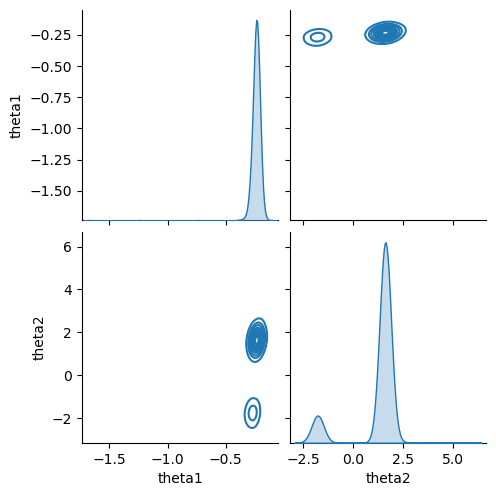

In [44]:
sns.pairplot(df,kind="kde")
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.show()

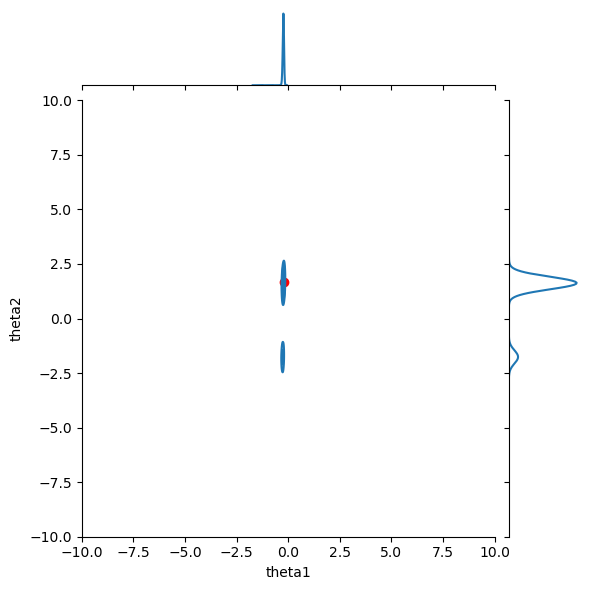

In [45]:
sns.jointplot(data=df,x="theta1", y="theta2", kind="kde")
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.show()

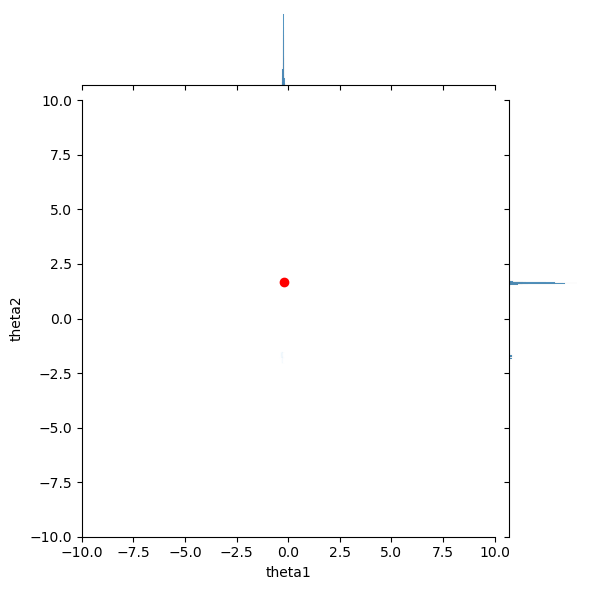

In [46]:
sns.jointplot(data=df,x="theta1", y="theta2", kind="hex")
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.show()

In [47]:
import corner

In [48]:
data_ = {"theta1":thetas_sampled[:, 0], "theta2":thetas_sampled[:, 1]}

In [68]:
m1=jnp.median(data_["theta1"])
s1=jnp.std(data_["theta1"])
m2=jnp.median(data_["theta2"])
s2=jnp.std(data_["theta2"])

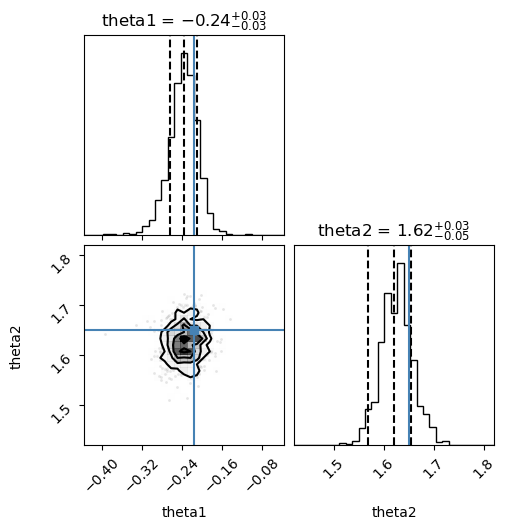

In [71]:
dx = 0.05
dy = 0.05

figure = corner.corner(data_, bins=31, range=[[m1-dx,m1+dx],[m2-dy,m2+dy]],
                       quantiles=[0.16, 0.5, 0.84],show_titles=True,
                       truths=theta_true[0],
                      plot_contours=True,
                      smooth=None)
#axes = np.array(figure.axes).reshape((2, 2))
#axes[1,0].scatter(theta_true[:,0], theta_true[:,1], color="red", zorder=10)
plt.show()

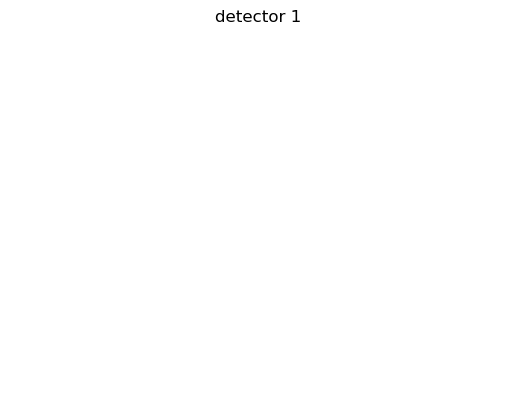

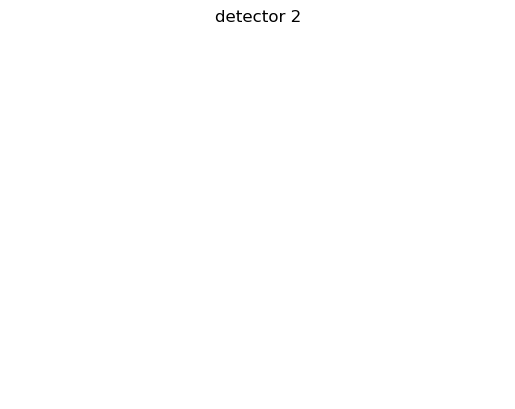

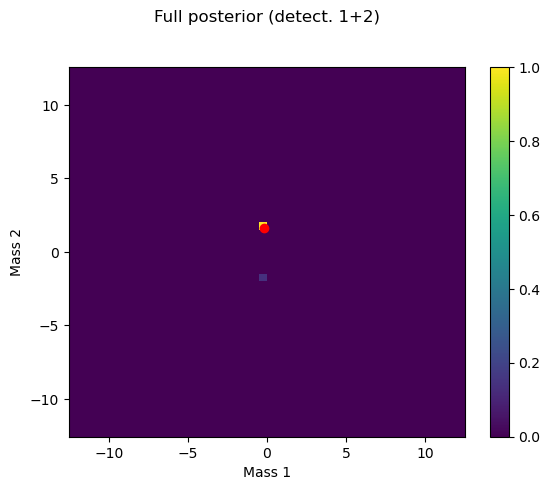

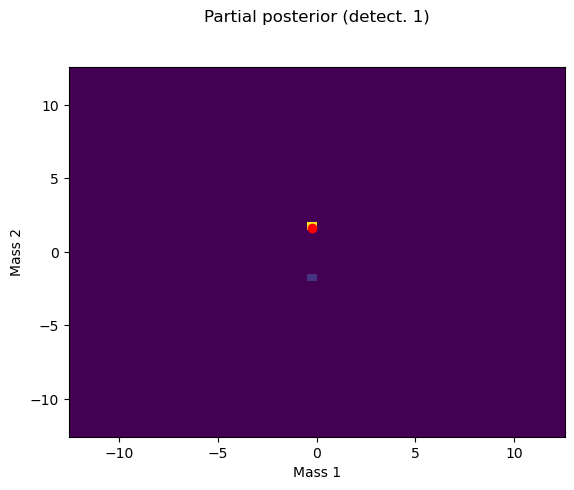

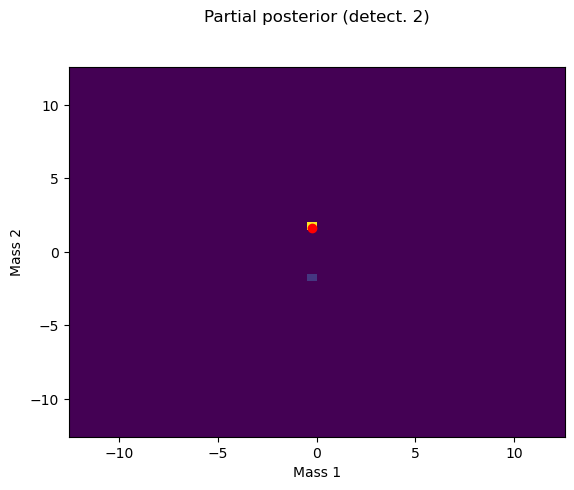

In [51]:
import matplotlib.gridspec as gridspec

# bins1 = np.linspace(-np.pi, np.pi, 101)
# bins2 = np.linspace(0, np.pi, 101)

#xlim = [-1,1]
#ylim=[1.2,2.0]
xlim = [-4*np.pi,4*np.pi]
ylim=[-4*np.pi,4*np.pi]

bins1 = np.linspace(*xlim, 51)
bins2 = np.linspace(*ylim, 51)


plt.plot(theta_true[0,0], lw=0.1, color="black")
plt.title("detector 1")
plt.axis("off")
plt.show()

plt.plot(theta_true[0,1],lw=0.1, color="black")
plt.title("detector 2")
plt.axis("off")
plt.show()


plt.hist2d(thetas_sampled[:, 0], thetas_sampled[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.colorbar()
# ax1.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.title("Full posterior (detect. 1+2)", y=1.1)
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()


plt.hist2d(thetas_partial1[:, 0], thetas_partial1[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")
plt.title("Partial posterior (detect. 1)", y=1.1)

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()


plt.hist2d(thetas_partial2[:, 0], thetas_partial2[:, 1], bins=[bins1,bins2], density=False)
plt.scatter(theta_true[:,0], theta_true[:,1], color="red")
plt.xlabel("Mass 1")
plt.ylabel("Mass 2")
plt.title("Partial posterior (detect. 2)", y=1.1)

plt.xlim(xlim)
plt.ylim(ylim)

plt.show()